In [36]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
import re
import seaborn as sns

from collections import Counter
from nltk import pos_tag, word_tokenize, classify, bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

In [2]:
edmunds = pd.read_csv("Assignment 3 Edmunds Posts.csv")
senti = pd.read_csv("Assignment 3 Sentiment Scores.csv")

# Part A

In [3]:
models = list(senti.columns.values)

In [4]:
#create dictionary out of sales for each car brand
CarSales = {'A6': 20000, 'A8':12000, '3series':220000, '5series': 60000, 
            '7series':14000,'XJ': 6600, 'ES':135000, 'LS':30000, 'RX': 120000, 'Sclass':25000}

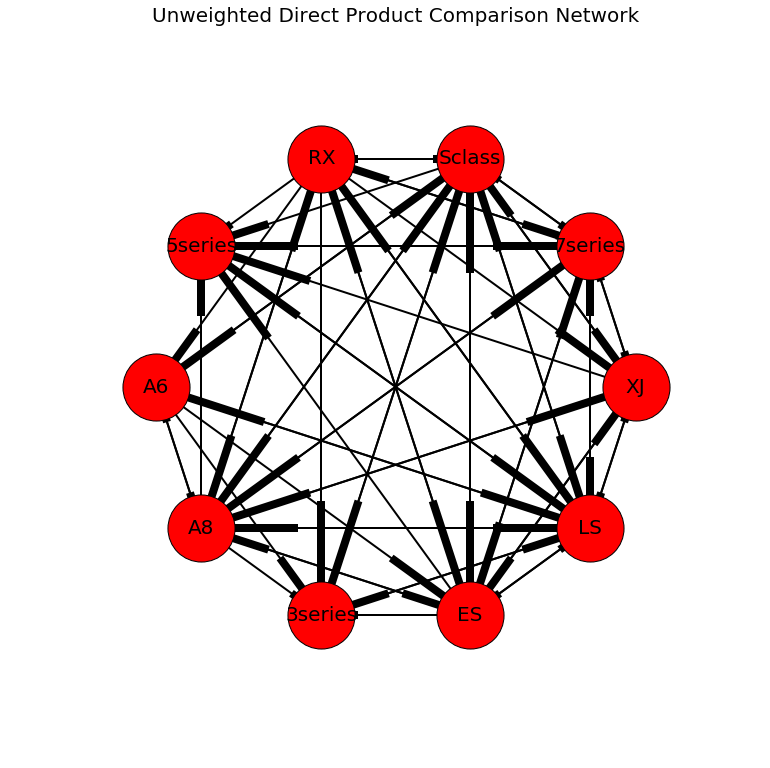

In [5]:
DG = nx.DiGraph()
for i in range(len(senti)):
    for x in senti.columns.values:
        if senti.ix[i][x] > 0:
            for y in senti.columns.values:
                if senti.ix[i][y] > 0:
                    if senti.ix[i][x] > senti.ix[i][y]:
                        if (x,y) not in DG.edges():
                            DG.add_edges_from([(x,y)])

# Create plot
plt.figure(figsize=(10,10))
nx.draw_circular(DG,nodelist=models, font_size=20, width=2, node_size=4500,with_labels=True)

plt.title("Unweighted Direct Product Comparison Network", fontsize=20)

pylab.show()

# Part B - Unweighted Pagerank Scores

In [6]:
unweighted_pr = [(key, round(nx.pagerank(DG, alpha=0.9, max_iter=1000)[key],3)) for key in nx.pagerank(DG, alpha=0.9, max_iter=1000)]
sorted(unweighted_pr, key=lambda tup:tup[1], reverse=True)

[('LS', 0.167),
 ('Sclass', 0.128),
 ('7series', 0.123),
 ('5series', 0.096),
 ('A8', 0.096),
 ('ES', 0.095),
 ('XJ', 0.083),
 ('3series', 0.078),
 ('RX', 0.076),
 ('A6', 0.057)]

#### Unweighted Pagerank correlations

In [51]:
#make dict out of list of tuples from pr scores
carPRscore = dict(unweighted_pr)

sales_corr = pd.DataFrame([carPRscore, CarSales]).T
sales_corr.columns = ['PageRank', 'Sales']
sales_corr.corr()

,PageRank,Sales
PageRank,1.000000,-0.322605
Sales,-0.322605,1.000000


Weighted PageRank v Sales


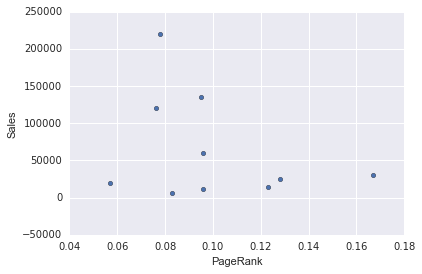

In [52]:
print "Weighted PageRank v Sales"
sales_corr.plot.scatter('PageRank','Sales')

### Weighted Pagerank

In [8]:
col = senti.columns
ar = []
for i in range(len(col)-1):
    for j in range(len(col)):
        if j>i:
            pos = senti[[col[i],col[j]]][(senti[col[i]]>senti[col[j]])]
            neg = senti[[col[i],col[j]]][senti[col[i]]<senti[col[j]]]
            posv = (pos[col[i]]-pos[col[j]]).sum()
            negv = (neg[col[j]]-neg[col[i]]).sum()
            sen = posv-negv
            ar.append((col[i],col[j],sen))

In [9]:
ar2=[]
for i in ar:
    if i[2]<0:
        ar2.append((i[1],i[0],-i[2]))
    else:
        ar2.append(i)

In [10]:
#get weighted pagerank scores
weighted_pr = nx.pagerank(DG, alpha=0.9)

weighted_pr

{'3series': 0.07772938190638201,
 '5series': 0.09584153689487782,
 '7series': 0.12313829920951432,
 'A6': 0.05678297873147968,
 'A8': 0.09642048373161603,
 'ES': 0.09533710907047749,
 'LS': 0.16742697192682052,
 'RX': 0.07576390560855353,
 'Sclass': 0.1282189374829038,
 'XJ': 0.08334039543737466}

In [11]:
page_rank_arr = []
page_rank_arr2 = []
for i in col:
    page_rank_arr.append((i,weighted_pr[i]*25000))
    page_rank_arr2.append(weighted_pr[i]*25000)

In [12]:
DG=nx.DiGraph()
DG.add_nodes_from(models,node_size=page_rank_arr)
DG.add_weighted_edges_from(ar2)

In [13]:
t = []
for i in range(len(col)):
    t.append(i*1000)

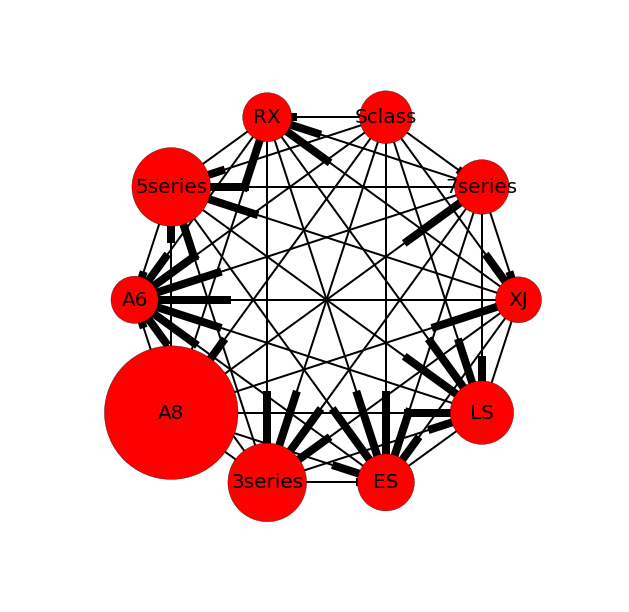

In [48]:
plt.figure(figsize=(8,8))
nx.draw_circular(DG,nodelist=models, font_size=20, width=2,
               node_size=page_rank_arr2,with_labels=True)

calculate correlation between pagerank score and carsales

In [49]:
#make dict out of list of tuples from pr scores
carPRscore = dict(weighted_pr)

sales_corr = pd.DataFrame([carPRscore, CarSales]).T
sales_corr.columns = ['PageRank', 'Sales']
sales_corr.corr()

,PageRank,Sales
PageRank,1.000000,-0.325356
Sales,-0.325356,1.000000


Weighted PageRank v Sales


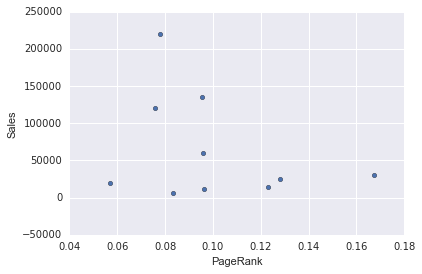

In [50]:
print "Weighted PageRank v Sales"
sales_corr.plot.scatter('PageRank','Sales')

Pagerank takes into account the magnitude of the difference in sentiment between the car brands, so weighted pagerank gives us a better idea of precisely how much more preferred one car brand is over another

# Part C

In [16]:
tokenizer = RegexpTokenizer("[\w]+")
lemmatize = WordNetLemmatizer().lemmatize
stop_words= stopwords.words('english')

In [17]:
edmunds_list = list(edmunds['Posts'])

SentiStrength_scores = pd.read_csv("SentiStrength_Dict.csv")
del SentiStrength_scores['Unnamed: 2']
SentiStrength_scores['word'].apply(lemmatize)
senti_dict = SentiStrength_scores.set_index('word')['score'].to_dict()

senti_dict

{'dissolution': -2,
 'desirable': 4,
 'chaos': -2,
 'obstruction': -2,
 'protest': -2,
 'thirst': -2,
 'hating': -4,
 'hate': -4,
 'accus': -2,
 'vile': -4,
 'spew': -2,
 'scold': -2,
 'unsteadiness': -2,
 'daze': -2,
 'sputter': -2,
 'immature': -2,
 'pride': 2,
 'whack': -2,
 'lure': -2,
 'risk': -2,
 'compassion': 2,
 'dispense': -2,
 'void': -2,
 'lurk': -1,
 'distort': -2,
 'smack': -2,
 'disobedient': -2,
 'senil': -2,
 'disturb': -2,
 'prize': 3,
 'pinch': -2,
 'graced': 2,
 'paranoi': -3,
 'brutish': -2,
 'desperat': -3,
 'deplorable': -2,
 'graces': 2,
 'triumph': 3,
 'enjoy': 3,
 'force': -2,
 'monotonous': -2,
 'popularis': 1,
 'tired': -2,
 'populariz': 1,
 'crave': -2,
 'horr': -4,
 'rigorous': 1,
 'sternly': -2,
 'emptiness': -3,
 'decadence': -2,
 'wreck': -2,
 'ruthless': -3,
 'amus': 2,
 'beaten': -1,
 'litig': -2,
 'hazy': -2,
 'mischievous': -2,
 'sunder': -2,
 'blur': -2,
 'neat': 1,
 'admiral': 1,
 'hero': 3,
 'avert': -2,
 'tyranous': -3,
 'sobs': -4,
 'unfeeling'

In [18]:
def SentiRate(tokens_list):
    '''Takes list of tokens and returns a cumulative sentiment score for the
    entire list'''
    sentence_score = 0
    for token in tokens_list:
        if token in senti_dict.keys():
            token_score = senti_dict[token]
            sentence_score += token_score
    return sentence_score

In [19]:
# Initialize dictionary
edmunds_dict = {}
for item in models:
    edmunds_dict[item] = []
for key in edmunds_dict:
    edmunds_dict[key] = [0]*len(edmunds)

In [20]:
i = 0
for review in edmunds_list:
    sentences = []
    for sent in re.split(r'[.]+', review):
        sentences.append(sent)
    for sentence in sentences:
        tokens = [token.lower() for token in tokenizer.tokenize(sentence)]
        tokens = [lemmatize(token) for token in tokens]
        for model in models:
            if model.lower() in tokens:
                sentence_score = SentiRate(tokens)
                edmunds_dict[model][i] += sentence_score
    i += 1

In [21]:
edmunds_scores = pd.DataFrame(edmunds_dict)
edmunds_scores.head()

,3series,5series,7series,A6,A8,ES,LS,RX,Sclass,XJ
0,0,0,0,0,-1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,2,0,0
4,-4,0,0,0,0,0,0,-4,-2,0


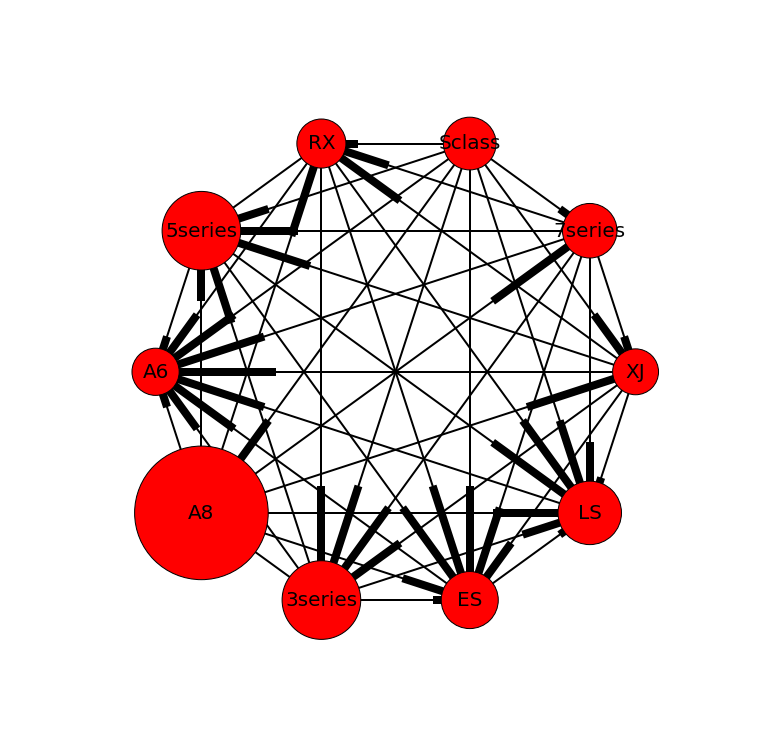

In [22]:
nodes = list(edmunds_scores.columns.values)
col = edmunds_scores.columns
ar = []
for i in range(len(col)-1):
    for j in range(len(col)):
        if j>i:
            pos = edmunds_scores[[col[i],col[j]]][(edmunds_scores[col[i]]>
                                                   edmunds_scores[col[j]])]
            neg = edmunds_scores[[col[i],col[j]]][edmunds_scores[col[i]]<
                                                  edmunds_scores[col[j]]]
            posv = (pos[col[i]]-pos[col[j]]).sum()
            negv = (neg[col[j]]-neg[col[i]]).sum()
            sen = posv-negv
            ar.append((col[i],col[j],sen))
            
ar2=[]
for i in ar:
    if i[2]<0:
        ar2.append((i[1],i[0],-i[2]))
    else:
        ar2.append(i)
        
DG=nx.DiGraph()
DG.add_nodes_from(nodes)
DG.add_weighted_edges_from(ar2)

pr = nx.pagerank(DG, alpha=0.9)

page_rank_arr = []
page_rank_arr2 = []
for i in col:
    page_rank_arr.append((i,pr[i]*50000))
    page_rank_arr2.append(pr[i]*50000)
    
DG=nx.DiGraph()
DG.add_nodes_from(nodes,node_size=page_rank_arr)
DG.add_weighted_edges_from(ar2)
    
plt.figure(figsize=(10,10))
nx.draw_circular(DG,nodelist=models, font_size=20, width=2,
               node_size=page_rank_arr2,with_labels=True)

In [23]:
for key, value in sorted(pr.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %s" % (key, value)

Sclass: 0.0421298716323
A8: 0.0445266407888
7series: 0.048188411991
XJ: 0.0555901869666
RX: 0.0594795030548
3series: 0.0651312972486
5series: 0.0806431218874
ES: 0.123657476162
LS: 0.123657476162
A6: 0.356996014106


In [24]:
carPRscore = dict(pr)

keys = list(carPRscore.viewkeys() | CarSales.viewkeys())
y=0
while (y < 10):
    print keys[y]," : ", np.corrcoef([carPRscore.get(x, y) for x in keys], [CarSales.get(x, y) for x in keys])[0,1]
    y+=1

XJ  :  -0.127618929417
7series  :  -0.127618929417
Sclass  :  -0.127618929417
RX  :  -0.127618929417
5series  :  -0.127618929417
A6  :  -0.127618929417
A8  :  -0.127618929417
3series  :  -0.127618929417
ES  :  -0.127618929417
LS  :  -0.127618929417


In [34]:
sales_corr = pd.DataFrame([carPRscore, CarSales]).T
sales_corr.columns = ['PageRank', 'Sales']
sales_corr.corr()

,PageRank,Sales
PageRank,1.000000,-0.127619
Sales,-0.127619,1.000000


Weighted PageRank v Sales


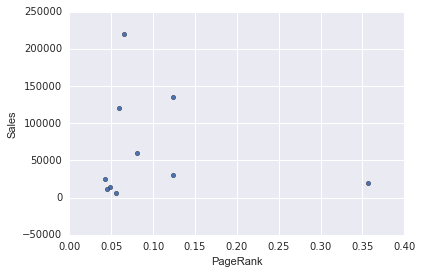

In [47]:
print "Weighted PageRank v Sales"
sales_corr.plot.scatter('PageRank','Sales')